Important Libraries

In [1]:
!pip install yfinance --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

Download Stock Data

In [2]:
ticker = 'AAPL'
start_date = '2012-01-01'
end_date = '2020-12-31'

df = yf.download(ticker, start=start_date, end=end_date)
df = df[['Close']]
df.dropna(inplace=True)
df.head()


/tmp/ipython-input-2-631822633.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,AAPL
Date,
2012-01-03,12.359182
2012-01-04,12.425603
2012-01-05,12.563555
2012-01-06,12.694892
2012-01-09,12.674751


Visualize Stock Price

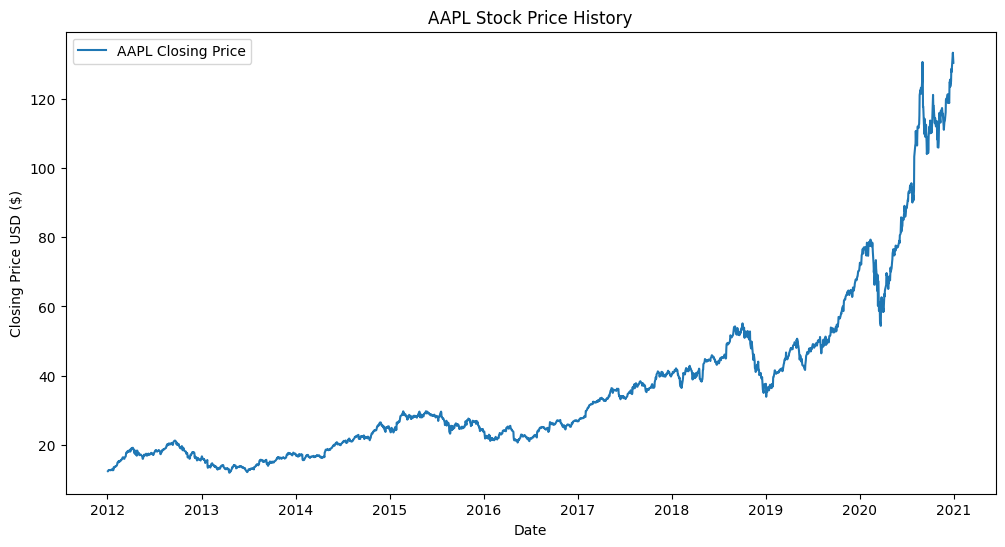

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label=f'{ticker} Closing Price')
plt.title(f'{ticker} Stock Price History')
plt.xlabel('Date')
plt.ylabel('Closing Price USD ($)')
plt.legend()
plt.show()

Data Preprocessing

In [4]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df)

# Split into training & testing
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - 60:]  # for sliding window

# Create dataset function
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i - time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_data)
X_test, y_test = create_dataset(test_data)

# Reshape input for LSTM: (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test,  (X_test.shape[0],  X_test.shape[1], 1))


Build the LSTM Model

In [5]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

Train the Model

In [6]:
history = model.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=0.1)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0062 - val_loss: 0.0012
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 2.0520e-04 - val_loss: 3.4167e-04
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 7.6204e-05 - val_loss: 3.2926e-04
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 6.4542e-05 - val_loss: 3.3539e-04
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 5.8906e-05 - val_loss: 3.5828e-04
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 6.5025e-05 - val_loss: 3.6443e-04
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 5.8391e-05 - val_loss: 3.1148e-04
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 5.6585e-05 - val_loss: 3.4046e-04
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 5.6651e-05 - val_loss: 3.1061e-04
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 5.3108e-05 - val_loss: 2.9639e-04


Predict & Visualize

In [7]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


Plot

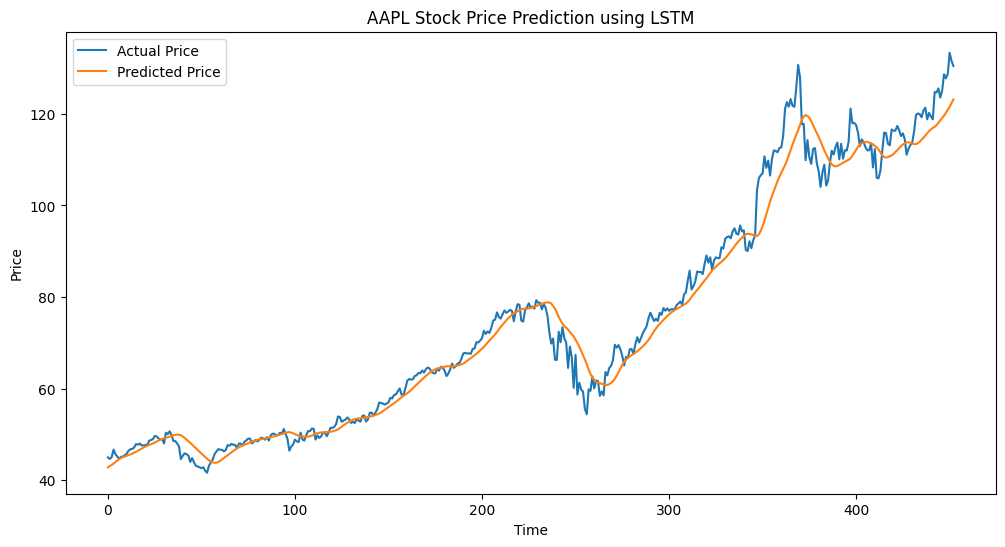

In [8]:
plt.figure(figsize=(12,6))
plt.plot(actual, label='Actual Price')
plt.plot(predictions, label='Predicted Price')
plt.title(f'{ticker} Stock Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [9]:
#  Evaluate Model

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(actual, predictions))
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')


Root Mean Squared Error (RMSE): 4.05
